In [2]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [8]:
install.packages("patchwork")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [9]:
# ================================
# Importar librerías
# ================================
library(caret)      # para train/test split
library(ggplot2)    # para gráficos
library(dplyr)      # manipulación de datos
library(patchwork)  # para unir gráficos
set.seed(123)  # reproducibilidad

In [10]:
# ================================
# Generación de datos
# ================================
x <- runif(1000, 0, 1)     # variable independiente
e <- rnorm(1000, 0, 1)     # ruido
y <- x + e                 # variable dependiente

# ================================
# Número de features (grados del polinomio)
# ================================
features_range <- c(1, 2, 5, 10, 20, 50, 100, 200, 500, 1000)

# Listas para resultados
r2_list <- c()
adj_r2_list <- c()
oos_r2_list <- c()

n <- length(y)

In [14]:
# ================================
# Bucle
# ================================
for (p in features_range) {
  # Crear matriz de diseño con nombres consistentes
  X_design <- sapply(1:p, function(i) x^i)
  colnames(X_design) <- paste0("X", 1:p)
  X_design <- as.data.frame(X_design)

  # Estimación en muestra completa
  fullData <- data.frame(y = y, X_design)
  model <- lm(y ~ . - 1, data = fullData)
  y_pred_full <- predict(model, newdata = fullData)

  # Calcular R²
  ss_res <- sum((y - y_pred_full)^2)
  ss_tot <- sum((y - mean(y))^2)
  R_sq <- 1 - (ss_res / ss_tot)
  r2_list <- c(r2_list, R_sq)

  # Calcular adjusted R²
  k <- p
  if (n > k + 1) {
    adjR_sq <- 1 - ((1 - R_sq) * (n - 1) / (n - k - 1))
  } else {
    adjR_sq <- NA
  }
  adj_r2_list <- c(adj_r2_list, adjR_sq)

  # Train/test split
  trainIndex <- createDataPartition(y, p = 0.75, list = FALSE)
  X_train <- X_design[trainIndex, ]
  X_test  <- X_design[-trainIndex, ]
  y_train <- y[trainIndex]
  y_test  <- y[-trainIndex]

  trainData <- data.frame(y = y_train, X_train)
  testData  <- data.frame(y = y_test, X_test)

  model_train <- lm(y ~ . - 1, data = trainData)
  y_pred_test <- predict(model_train, newdata = testData)

  # Calcular out-of-sample R²
  ss_res_test <- sum((y_test - y_pred_test)^2)
  ss_tot_test <- sum((y_test - mean(y_test))^2)

  if (ss_tot_test > 0) {
    oos_r2 <- 1 - (ss_res_test / ss_tot_test)
  } else {
    oos_r2 <- NA
  }
  oos_r2_list <- c(oos_r2_list, oos_r2)
}

Warning message:
“'newdata' had 248 rows but variables found have 752 rows”
Warning message in y_test - y_pred_test:
“longer object length is not a multiple of shorter object length”


In [15]:
# ================================
# Preparar datos para gráficos
# ================================
results <- data.frame(
  features = features_range,
  R2 = r2_list,
  Adj_R2 = adj_r2_list,
  OOS_R2 = oos_r2_list
)

# Filtrar NA para gráficos
results_plot <- results %>% filter(!is.na(Adj_R2), !is.na(OOS_R2))

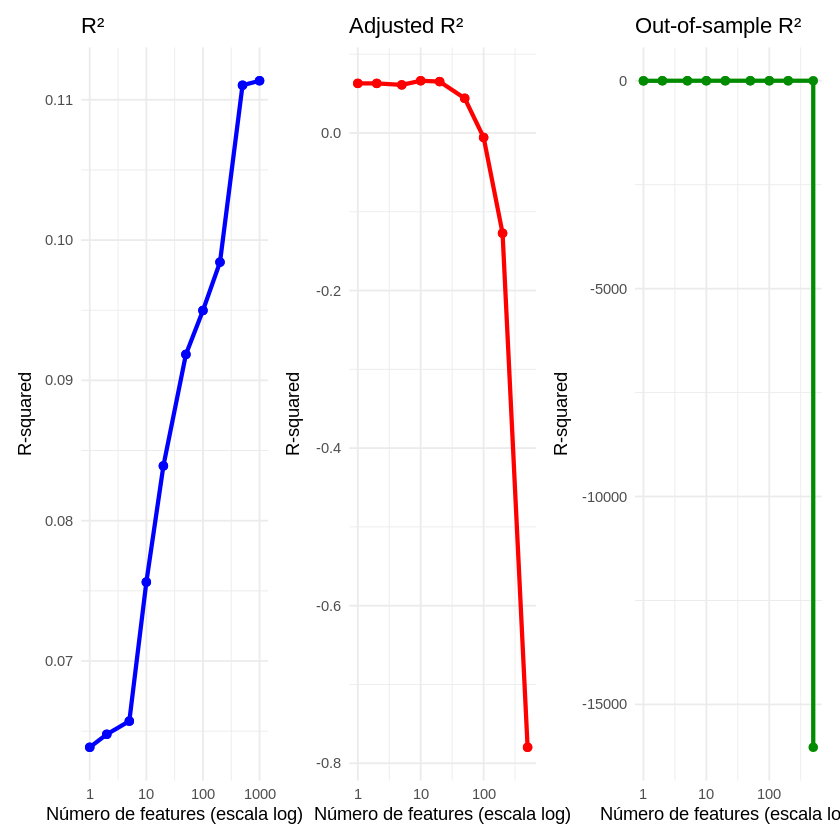

In [16]:
# ================================
# Gráficos
# ================================
p1 <- ggplot(results, aes(x = features, y = R2)) +
  geom_line(color = "blue", linewidth = 1.2) +
  geom_point(color = "blue", size = 2) +
  scale_x_log10() +
  labs(title = "R²", x = "Número de features (escala log)", y = "R-squared") +
  theme_minimal()

p2 <- ggplot(results_plot, aes(x = features, y = Adj_R2)) +
  geom_line(color = "red", linewidth = 1.2) +
  geom_point(color = "red", size = 2) +
  scale_x_log10() +
  labs(title = "Adjusted R²", x = "Número de features (escala log)", y = "R-squared") +
  theme_minimal()

p3 <- ggplot(results_plot, aes(x = features, y = OOS_R2)) +
  geom_line(color = "green4", linewidth = 1.2) +
  geom_point(color = "green4", size = 2) +
  scale_x_log10() +
  labs(title = "Out-of-sample R²", x = "Número de features (escala log)", y = "R-squared") +
  theme_minimal()

(p1 | p2 | p3)